In [120]:
using CSV, DataFrames, Plots, Statistics, JuMP, Gurobi, StatsBase

In [121]:
pollution = DataFrame(CSV.File("Data/pollution_location.csv"))
pollution_xy = pollution[:,1:2]|>Matrix
densities = DataFrame(CSV.File("Data/density_location.csv"))
sensors = DataFrame(CSV.File("Data/sensors_location.csv"))
sensors_xy = sensors[:,1:2]|>Matrix;

In [122]:
lat_to_km = [111, 92]
lat_diff = (pollution_xy[:,1].-sensors_xy[:,1]').*lat_to_km[1]
long_diff = (pollution_xy[:,2].-sensors_xy[:,2]').*lat_to_km[2]

dist_matrix = sqrt.(lat_diff.^2 + long_diff.^2)';
rows_to_keep = findall(row -> any(iszero, row), eachrow(dist_matrix))
dist_matrix = dist_matrix[rows_to_keep, :]
sensors_xy = sensors_xy[rows_to_keep, :];

In [123]:
density

Row,latitude,longitude,density
,Float64,Float64,Float64
1,33.7082,-118.287,1.30231
2,33.7191,-118.323,1.55719
3,33.7191,-118.314,1.547
4,33.7191,-118.305,1.48912
5,33.7191,-118.296,1.43123
6,33.7191,-118.287,1.37335
7,33.7191,-118.251,1.35686
8,33.73,-118.35,1.40214
9,33.73,-118.341,1.46163


In [124]:
dens = densities.density
dens = max.(dens,0.5)
r1 = 0
r2 = 2.5
r3 = 8
d1 = ((dist_matrix' .* dens)' .<= r1)
d2 = (r1 .< (dist_matrix' .* dens)' .<= r2)
d3 = (r2 .< (dist_matrix' .* dens)' .<= r3)
q = pollution.AIQ

n, m = size(dist_matrix)

(1780, 7107)

In [125]:
q_sen = (dist_matrix.==0) * q
function loss(x, q, k)
    x = round.(x)
    d = 1 ./(dist_matrix .+ 10 .*(1 .-x) .* maximum(dist_matrix) .+ 1)
    dq = d .* q_sen
    q_pred = zeros(size(q))
    for j = 1:size(q, 1)
        indices = partialsortperm(d[:,j], 1:k, rev=true)
        if d[indices[1], j]==1
            q_pred[j] = q_sen[indices[1]]
        else
            q_pred[j] = sum(dq[indices, j].*x[indices])/sum(d[indices, j].*x[indices])
        end
    end
    return sum((q_pred - q).^2)/sum(q.^2)
end


loss (generic function with 1 method)

In [126]:
function model1c()
    model = Model(Gurobi.Optimizer);
    set_optimizer_attribute(model, "TimeLimit", 120);
    
    @variable(model, x[1:n], Bin) #Whether we put a sensor at spot i
    @variable(model, y1[1:m].<=1) #Whether spot j is covered closely
    @variable(model, y2[1:m].<=1) #Whether spot j is covered at a distance
    @variable(model, y3[1:m].<=1) #Whether spot j is covered at a distance
    
    @constraint(model, y1'.<= x'*d1)
    @constraint(model, y2'.<= x'*d2)
    @constraint(model, y3'.<= x'*d3)
    @constraint(model, y1 .+ y2 .+ y3 .<=1)
    @constraint(model, sum(x)<=348) # Check this number
    
    @objective(model, Max, sum(y1.*q) + 1/8*sum(y2.*q) + 1/64*sum(y3.*q))
    optimize!(model)
    return value.(x), value.(y1), value.(y2), value.(y3)
end
x, y1, y2, y3 = model1c()
sum(x)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-18
Set parameter TimeLimit to value 120
Set parameter TimeLimit to value 120
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 28429 rows, 23101 columns and 735006 nonzeros
Model fingerprint: 0x77a116cc
Variable types: 21321 continuous, 1780 integer (1780 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 9e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective -0.0000000
Presolve removed 8431 rows and 8045 columns
Presolve time: 0.78s
Presolved: 19998 rows, 15056 columns, 718522 nonzeros
Variable types: 0 continuous, 15056 integer (12486 binary)
Found heuristic solution: objective 32803.490120
Deterministic concurrent LP optimizer: primal and dual simp

348.0

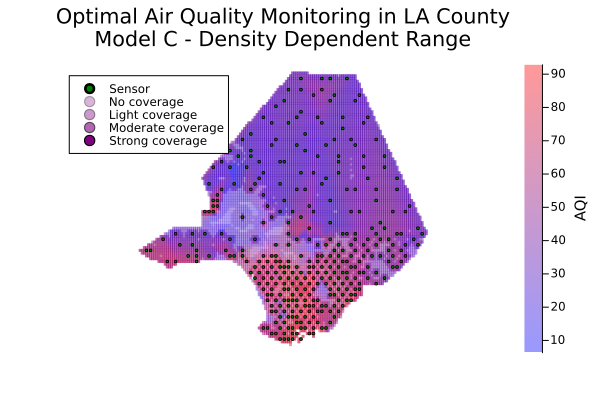

In [133]:
sensors = sensors_xy[x .== 1, :]

scatter(pollution_xy[:, 2], pollution_xy[:, 1], 
    marker_z=q, 
    color=cgrad([:blue, :red]), 
    alpha= .3 .+ 0.7 .* y1 + 0.3 .* y2 + 0.1 .* y3 ,
    markersize=1.5, 
    shape=:rect,  
    markerstrokewidth=0,
    label="",
    ratio = 1.1,
    colorbar=true, colorbar_title = "AQI", legend=:topleft, axis = false, grid = false,
    )

scatter!(
        sensors[:, 2], sensors[:, 1],  
        color="green",
        markersize = 1.5, 
        label = "Sensor"
    )

scatter!([NaN], [NaN], alpha = 0.3, color = :purple, shape = :circle, label = "No coverage")
scatter!([NaN], [NaN], alpha = 0.4, color = :purple, shape = :circle, label = "Light coverage")
scatter!([NaN], [NaN], alpha = 0.6, color = :purple, shape = :circle, label = "Moderate coverage")
scatter!([NaN], [NaN], alpha = 1, color = :purple, shape = :circle, label = "Strong coverage")


# Add a title with better formatting
title!("Optimal Air Quality Monitoring in LA County\nModel C - Density Dependent Range")

In [128]:
loss(x, q, 5)

0.03241554755713685